## Introduction

I obtained data on Airbnbs in Edinburgh for both 2019/20 (compiled on 25th June 2019) and 2020/21 (compiled on 23rd June 2020). All of the data were collected by the [Inside Airbnb](http://insideairbnb.com/get-the-data.html) project, although only the most recent year is available on their website. The 2019-20 data were sourced on [Kaggle](https://www.kaggle.com/thoroc/edinburgh-inside-airbnb). Here, I take a first look at the listings from the **2020/21** data. This is a verbose description of my initial exploration of the **listings** dataset. The time series data is discussed elsewhere. By the end of this notebook, I will have a clean, complete, and properly encoded dataset ready for integration with the time series data, then modelling. 

This dataset contains 106 fields describing 12,658 Airbnb listings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

listings = pd.read_csv('../data20/listings.csv')

listings.shape

(12658, 106)

## Missing Data & Duplicates

There are missing data in this dataset. The variables that tend to contain missing data are very similar to those that had missing data in the 2019 dataset. The proportion of missing data within a certain column is also strikingly similar.

In [2]:
listings = listings.drop_duplicates()
listings.isna().any().any()

True

In [3]:
listings.loc[:, listings.isnull().any()].columns

Index(['summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'xl_picture_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'revi

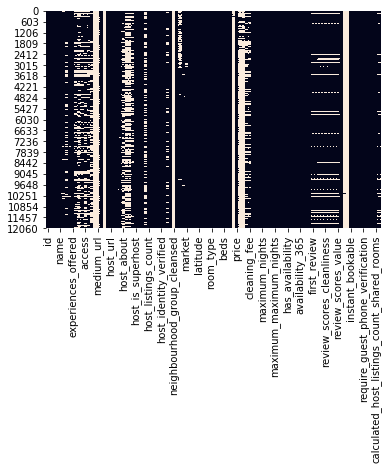

In [4]:
sn.heatmap(listings.isnull(), cbar=False)

In [5]:
print("% missing values for columns with missing values")
for (columnName, contents) in listings.iteritems():
    missing = 100 - ((len(listings.index) - contents.isnull().sum())/len(listings.index) * 100)
    if (missing != 0):
        print(columnName, ": ", "{0:.2f}".format(missing))

% missing values for columns with missing values
summary :  3.29
space :  21.13
description :  1.33
neighborhood_overview :  27.20
notes :  54.39
transit :  26.79
access :  34.19
interaction :  28.22
house_rules :  38.83
thumbnail_url :  100.00
medium_url :  100.00
xl_picture_url :  100.00
host_name :  0.01
host_since :  0.01
host_location :  0.28
host_about :  42.38
host_response_time :  66.58
host_response_rate :  66.58
host_acceptance_rate :  22.32
host_is_superhost :  0.01
host_thumbnail_url :  0.01
host_picture_url :  0.01
host_neighbourhood :  44.04
host_listings_count :  0.01
host_total_listings_count :  0.01
host_has_profile_pic :  0.01
host_identity_verified :  0.01
neighbourhood :  17.56
neighbourhood_group_cleansed :  100.00
city :  0.28
state :  17.66
zipcode :  1.49
market :  1.34
bathrooms :  0.05
bedrooms :  0.06
beds :  0.27
bed_type :  0.01
square_feet :  99.77
weekly_price :  92.27
monthly_price :  94.77
security_deposit :  34.03
cleaning_fee :  26.84
first_review :  

I remove any columns that I am not interested in or that have a very high rate of missingness. I take a complete cases approach to missingness for the neighbourhood column. Columns that I am interested in that have a very low percentage missingness or whose missingess is consistent throughout a category (e.g. ratings) are median imputed if continuous, or replaced with the most popular value if binary.

In [6]:
listings = listings.drop(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_thumbnail_url',
              'host_picture_url', 'city', 'state', 'license', 'jurisdiction_names',
              'experiences_offered', 'access', 'interaction', 'has_availability', 'market', 
              'neighbourhood_group_cleansed', 'host_acceptance_rate', 'zipcode', 'square_feet',
              'weekly_price', 'monthly_price', 'name', 'host_total_listings_count', 'country_code'],
              axis = 1)

In [7]:
have_neighbourhood = np.invert(listings.neighbourhood.isnull().to_numpy())
listings = listings[have_neighbourhood]

In [8]:
for column in ['host_listings_count', 'bathrooms', 'beds', 'bedrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication',
              'review_scores_checkin', 'review_scores_location', 'reviews_per_month', 'review_scores_value']:
    listings.loc[(listings[column].isnull()), column] = listings[column].median()

In [9]:
# make all trues and falses into 1s and 0s 
listings = listings.replace('t', 1)
listings = listings.replace('f', 0)

In [10]:
for column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'host_response_rate']:
    listings.loc[(listings[column].isnull()), column] = listings[column].value_counts().index[0]

## Exploring Pricing

First I need to transform price columns into numeric values.

In [11]:
from pandas.api.types import is_numeric_dtype

def format_price(dataframe, column):
    if not is_numeric_dtype(dataframe[column]):
        dataframe[column] = dataframe[column].str.replace('$', '')
        dataframe[column] = dataframe[column].str.replace(',', '')
        dataframe[column] = pd.to_numeric(dataframe[column])

format_price(listings, "price")
format_price(listings, "extra_people")

Airbnbs can opt to charge extra for additional people staying in larger properties. The `price` column only refers to `guests_included`, and additional guests are charged at `extra_people`. Therefore, I can create another column which is price per included guest (`price_pig` = `price`/`guests_included`). I can also create a column that is price at full capacity (`price_fullcap` = `price` + `extra_people` * (`accomodates` - `guests_included`)). On 6 occassions this results in a negative number for `price_fullcap`, because the owner of the Airbnb has listed the price as including more individuals than the property can accomodate. In such cases, `price_fullcap` is just set to `price`.

In [12]:
listings = listings.assign(price_pig = lambda dataframe : dataframe['price']/dataframe['guests_included'])

listings = listings.assign(price_fullcap = lambda dataframe : dataframe['price'] + dataframe['extra_people'] * (dataframe['accommodates'] - dataframe['guests_included']))

listings.query('price_pig > price_fullcap')[['price_pig', 'price_fullcap', 'accommodates', 'price', 'extra_people', 'guests_included']]

listings['price_fullcap'] = np.where((listings.price_pig > listings.price_fullcap),listings.price,listings.price_fullcap)

### Distributions & Outlier Detection

The histogram of price per included guest shows an extreme right skew. Price here refers to the **mean** price per included guests per night over a 365 day period. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019DA7FBF3C8>]],
      dtype=object)

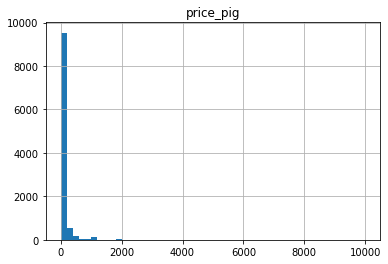

In [13]:
listings.hist(column = 'price_pig', bins = 50)

There are values of a dataset where the price per included guest is 0. The maximum price per included guest per night is £10,000. A really special feature of this dataset is that it includes the links to the Airbnb's pages. This means that, so long as the listing is still active, I can literally check to see if there is a reason that a value is extreme. I choose to use my own knowledge of hotel prices to create sensible upper and lower bounds for the data. Personally, I have found statistical methods (e.g. 3 standard deviations) often hide real features of the data. I use the price per included guest to make these judgements, because a property may appear to be an outlier just because it sleeps a large number of individuals. 

In [14]:
listings['price_pig'].min()

0.0

In [15]:
listings['price_pig'].max()

10000.0

Any Airbnb less than £8 per person a night would be a potential outlier, as this seems unreasonably cheap. There are 20 Airbnbs under £8 a night, and three of these are listed as costing nothing at all. I visually inspect these properties in the data for any feature that might explain this (e.g. they all have the same host, or are a special property type...). Airbnbs under £8 per person tend include many more people in the base rate than the mean for all Airbnbs in this dataset (mean ± standard deviation: 7.65 ± 4.75 ± vs. 1.77 ± 1.48). It makes sense that Airbnbs that include more people would be cheaper per person because the 'bare minimum' costs to the host are split between all of the people. 

In [16]:
listings[listings.price_pig < 8][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
578,7.000000,2,https://www.airbnb.com/rooms/3032366,14630118,6,74,2.0,Apartment,20.0
790,2.600000,3,https://www.airbnb.com/rooms/3769281,3713949,15,0,2.0,Apartment,0.0
925,6.250000,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
3239,2.916667,1,https://www.airbnb.com/rooms/13937408,82866543,12,296,1.0,Apartment,10.0
4544,1.636364,1,https://www.airbnb.com/rooms/18609453,101731795,11,48,1.0,Townhouse,0.0
4566,6.666667,3,https://www.airbnb.com/rooms/18664020,128824975,6,120,3.0,Apartment,100.0
4919,5.000000,1,https://www.airbnb.com/rooms/19346425,130895130,6,187,3.0,Apartment,0.0
4953,5.000000,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
5366,4.062500,3,https://www.airbnb.com/rooms/19903475,140937670,16,141,1.0,Apartment,0.0
5870,0.000000,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0


In fact, if I filter the results to only include Airbnbs with less than 5 guests (I choose this number because it is two deviations away from the mean for the whole sample), then I am only left with 5 results. Three of these are most likely errors as they are £0. I choose to exclude these 5 results.

In [17]:
listings[(listings.price_pig < 8) & (listings.guests_included < 5)][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
925,6.25,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
4953,5.00,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
5870,0.00,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
12331,0.00,1,https://www.airbnb.com/rooms/42279232,268308479,1,0,2.0,Boutique hotel,0.0


In [18]:
listings = listings[(listings.price > 8) | (listings.guests_included >= 5)]

A luxury apartment might charge £1000 a night per person if it was also centrally located. Moreover, recall that price here is derived from the mean price, so Airbnbs that are exclusively available on the night of some special event (e.g. the Edinburgh Hogmanay festival) may seem inflated compared to others. Note there is no way for me to check this because of the unreliability of the availability data (this will be discussed more in my EDA of the calendar dataset). Amazingly, there are 59 Airbnbs in this dataset that exceed £1000 per person per night. Here, I do observe some trends - there are some host ids that are enriched in these very expensive lets (e.g. 29783383, 50725883). After exploring some of the links, I could find no reason for these values (indeed, these values do not reflect what is currently on Airbnb for these properties, if their link was still valid). Due to this uncertainty, I choose to drop these data points.  

In [19]:
listings[listings.price_pig > 1000][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
183,3326.000000,1,https://www.airbnb.com/rooms/692353,3540219,6,344,3.0,Apartment,0.0
1617,8000.000000,9,https://www.airbnb.com/rooms/7361960,29783383,1,0,2.0,Apartment,0.0
2571,1500.000000,1,https://www.airbnb.com/rooms/12385633,21782787,1,0,1.0,Apartment,0.0
2974,3324.500000,1,https://www.airbnb.com/rooms/13487525,11362736,6,336,5.0,Apartment,0.0
3455,2415.000000,1,https://www.airbnb.com/rooms/14225887,86457709,1,0,1.0,Apartment,0.0
3699,1500.000000,2,https://www.airbnb.com/rooms/15081589,66064051,1,328,30.0,Townhouse,0.0
4137,1172.750000,2,https://www.airbnb.com/rooms/17167280,646220,4,57,1.0,Apartment,0.0
5681,7000.000000,2,https://www.airbnb.com/rooms/20258438,144388294,1,0,3.0,Apartment,200.0
5699,3000.000000,1,https://www.airbnb.com/rooms/20276442,41938554,1,0,1.0,Farm stay,10.0
5812,3327.500000,1,https://www.airbnb.com/rooms/20564259,22914282,6,355,4.0,Apartment,0.0


In [20]:
listings = listings[(listings.price < 1000)]

The skew in price per included guest is still very extreme. However, I am unwilling to blindly remove any more data points at this stage without further justification for their removal. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019DA809BDC8>]],
      dtype=object)

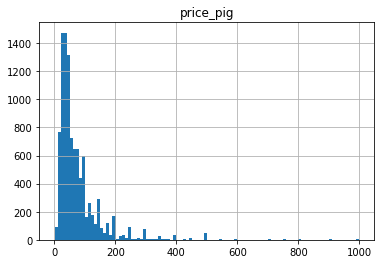

In [21]:
listings.hist(column = 'price_pig', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019DA962B4C8>]],
      dtype=object)

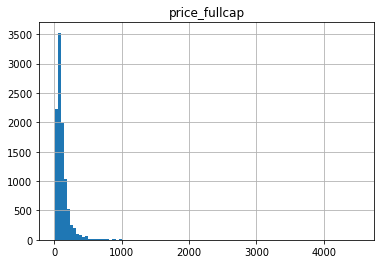

In [22]:
listings.hist(column = 'price_fullcap', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019DA416B788>]],
      dtype=object)

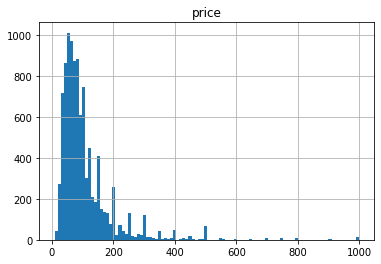

In [23]:
listings.hist(column = 'price', bins = 100)

## Exploring Ameneties 

I use the same process for one hot encoding amenities as I used in the 2019 dataset. Generally, all of the correlations are very similar betewen the two datasets. The main difference is that the workspace amenity did not occur in this dataset, which I find quite surprising given the increase in people working from home. 

In [24]:
def bath_bed_ratio(row):
    if row['beds'] == 0:
        return 1
    else:
        return row['bathrooms']/row['beds']
    
listings['bath_bed_ratio'] = listings.apply(lambda row: bath_bed_ratio(row), axis = 1)

In [25]:
listings['bath_bed_ratio'] = listings['bathrooms']/listings['beds']
listings['real_bed'] = listings['bed_type'].apply(lambda x: 1 if (x == 'Real Bed') else 0)

def countAmenities(search_term, col_name):
    listings[col_name] = listings['amenities'].apply(lambda x: 1 if search_term in x else 0)
    return(listings)

amenitiesDict = {
    "pets": "Pets allowed",
    "children": "Family/kid friendly",
    "aircon": "Air conditioning",
    "wifi": "Wifi",
    "washer": "Washer",
    "garden": "Garden or backyard",
    "oven": "Oven",
    "gym": "Gym",
    "tv": "TV",
    "cable": "Cable TV",
    "free_parking": "Free parking on premises",
    "breakfast": "Breakfast",
    "dishwasher": "Dishwasher",
    "crib": "Crib",
    "workspace": "Laptop friendly workspace",
    "lift": "Elevator",
    "wheelchair_access": "Wheelchair accessible",
    "balcony": "Patio or balcony",
    "bathtub": "Bathtub",
    "lugagge_dropoff": "Luggage dropoff allowed",
    "self_checkin": "Self check-in",
    "dryer": "Dryer",
    "waterfront": "Waterfront",
    "fireplace": "Indoor fireplace"
}


for key in amenitiesDict:
    listings = countAmenities(amenitiesDict[key], key)

In [26]:
corrMatrix = listings[["price", "price_pig", "price_fullcap"] + list(amenitiesDict.keys())].corr()
corrMatrix["price_pig"].sort_values()

oven                -0.074704
self_checkin        -0.064415
garden              -0.039174
bathtub             -0.031245
breakfast           -0.028957
wifi                -0.018434
lugagge_dropoff     -0.017144
dishwasher          -0.011970
free_parking        -0.008981
gym                  0.000339
children             0.001252
wheelchair_access    0.002863
balcony              0.004559
pets                 0.005332
waterfront           0.005778
cable                0.016413
washer               0.027865
crib                 0.033092
lift                 0.042803
fireplace            0.058836
aircon               0.080935
tv                   0.090937
dryer                0.107937
price_fullcap        0.696830
price                0.798673
price_pig            1.000000
workspace                 NaN
Name: price_pig, dtype: float64

I observe a stronger negative correlation between apartment and price than I did in the previous dataset. 

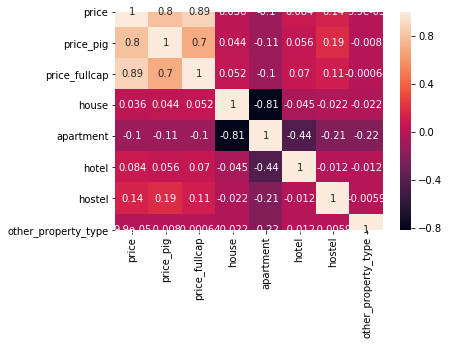

,price,price_pig,price_fullcap,house,apartment,hotel,hostel,other_property_type
price,1.000000,0.798673,0.886460,0.035734,-0.104800,0.083902,0.143138,0.000099
price_pig,0.798673,1.000000,0.696830,0.043885,-0.107034,0.055586,0.187986,-0.007976
price_fullcap,0.886460,0.696830,1.000000,0.051963,-0.104818,0.070402,0.113846,-0.000638
house,0.035734,0.043885,0.051963,1.000000,-0.812885,-0.045261,-0.022239,-0.022428
apartment,-0.104800,-0.107034,-0.104818,-0.812885,1.000000,-0.435130,-0.213800,-0.215615
hotel,0.083902,0.055586,0.070402,-0.045261,-0.435130,1.000000,-0.011904,-0.012005
hostel,0.143138,0.187986,0.113846,-0.022239,-0.213800,-0.011904,1.000000,-0.005899
other_property_type,0.000099,-0.007976,-0.000638,-0.022428,-0.215615,-0.012005,-0.005899,1.000000


In [27]:
listings['house'] = listings['property_type'].apply(lambda x: 1 if x in ['House', 'Cottage', 'Townhouse', 'Bungalow', 'Tiny house'] else 0)
listings['apartment'] = listings['property_type'].apply(lambda x: 1 if x in ['Apartment', 'Serviced apartment', 'Condominium', 'Aparthotel'] else 0)
listings['hotel'] = listings['property_type'].apply(lambda x: 1 if x in ['Boutique hotel', 'Guest suite', 'Guesthouse', 'Hotel', 'Bed and breakfast'] else 0)
listings['hostel'] = listings['property_type'].apply(lambda x: 1 if x in ['Hostel'] else 0)
listings['other_property_type'] = listings['property_type'].apply(lambda x: 1 if x in ['Loft', 'Villa', 'Camper/RV', 'Other', 'Tent', 'Cabin', 'Campsite', 'Chalet', 'Hut', 'Casa particular (Cuba)', 'Farm stay', 'Barn', 'Boat'] else 0)

corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'house', 'apartment', 'hotel', 'hostel', 'other_property_type']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Exploring Neighbourhoods

### One Hot Encoding

In [28]:
areas = pd.get_dummies(listings.neighbourhood, prefix='Area')
areas['id'] = listings['id']
listings = listings.merge(areas, on = 'id')
listings.head()

,id,listing_url,scrape_id,last_scraped,summary,space,description,neighborhood_overview,notes,transit,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20200623173438,2020-06-24,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...","The neighbourhood is in the historic New Town,...",Please note that because of my interest in int...,It is easy to walk to many of the main tourist...,...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20200623173438,2020-06-24,Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,It's all in the mix: Culture-museums and galle...,The apartment is in the City centre so being a...,Walk to key central attractions or catch a bus...,...,0,0,0,0,1,0,0,0,0,0
2,44552,https://www.airbnb.com/rooms/44552,20200623173438,2020-06-24,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,NaN,NaN,There are frequent buses to the centre and oth...,...,1,0,0,0,0,0,0,0,0,0
3,47616,https://www.airbnb.com/rooms/47616,20200623173438,2020-06-24,Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,We're at the quiet end of a residential street...,"As we are both working office-hours, arrivals ...",There are 30 bus routes within 5 minutes' walk...,...,0,0,0,0,0,0,1,0,0,0
4,48645,https://www.airbnb.com/rooms/48645,20200623173438,2020-06-24,Large comfortable private room in the heart of...,Your room is large with a very comfortable hig...,Large comfortable private room in the heart of...,The Canongate is an area rich in culture and h...,Edinburgh city center now has free unlimited w...,The apartment is 400 metres from the Airport B...,...,0,0,0,0,0,1,0,0,0,0


In [29]:
from itertools import chain

corrMatrix = listings[['price',
 'price_pig',
 'price_fullcap',
 'Area_Bruntsfield',
 'Area_Cannonmills',
 'Area_Haymarket',
 'Area_Leith',
 'Area_Marchmont',
 'Area_Morningside',
 'Area_New Town',
 'Area_Newington',
 'Area_Old Town',
 'Area_Southside',
 'Area_Stockbridge',
 'Area_Tollcross',
 'Area_West End']].corr()
corrMatrix["price_pig"].sort_values()

Area_Leith         -0.080053
Area_Haymarket     -0.035577
Area_Morningside   -0.019371
Area_Cannonmills   -0.015609
Area_Tollcross     -0.014776
Area_Newington     -0.000972
Area_Southside      0.001788
Area_Bruntsfield    0.003564
Area_West End       0.004559
Area_Stockbridge    0.006271
Area_Marchmont      0.022273
Area_Old Town       0.070210
Area_New Town       0.077669
price_fullcap       0.696830
price               0.798673
price_pig           1.000000
Name: price_pig, dtype: float64

## Exploring Ratings and Host Characteristics

### Distributions and Outlier Detection

There are slightly fewer hosts in this dataset compared to the 2019 dataset: only 7,178 unique hosts. The distributions for ratings and host characteristics are very similar to the 2019/20 data. I create a `host_in_edin` variable that indicates whether the host is local.

In [30]:
len(listings.host_id.unique())

7178

In [31]:
host_in_edin = [1 if area == "Edinburgh, Scotland, United Kingdom" else 0 for area in listings.host_location]
listings['host_in_edin'] = host_in_edin

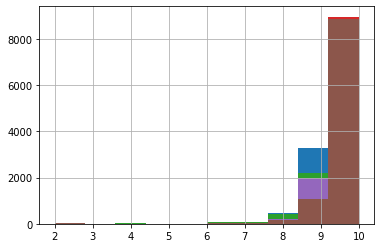

In [32]:
for rating in ['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_checkin']:
    listings[rating].hist()

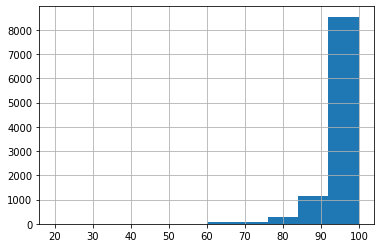

In [33]:
listings['review_scores_rating'].hist()

The percentage of hosts verified and that are superhosts is also similar to the previous year.

In [34]:
def get_percent_true(col, df):
    return sum(df[col] == 't')/len(df.index) * 100

print("% hosts that are verified: ", get_percent_true('host_identity_verified', listings))
print("% hosts that are superhosts: ", get_percent_true('host_is_superhost', listings))

def code_as_nums(series):
    return [1 if i == 't' else 0 for i in series]

listings.host_is_superhost = code_as_nums(listings.host_is_superhost)
listings.host_identity_verified = code_as_nums(listings.host_identity_verified)

% hosts that are verified:  0.0
% hosts that are superhosts:  0.0


C:\Users\s1533194\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


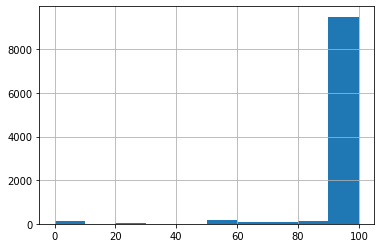

In [35]:
response_time = []

for item in listings.host_response_time:
    if item == "within an hour":
        response_time.append(3)
    elif item == "within a few hours":
        response_time.append(2)
    elif item == "within a day":
        response_time.append(1)
    elif item == "a few days or more":
        response_time.append(0)
    else:
        response_time.append(None)
        
listings['host_response_time'] = response_time

listings['host_response_rate'] = listings['host_response_rate'].str.replace('%', '')
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings.host_response_rate.hist()

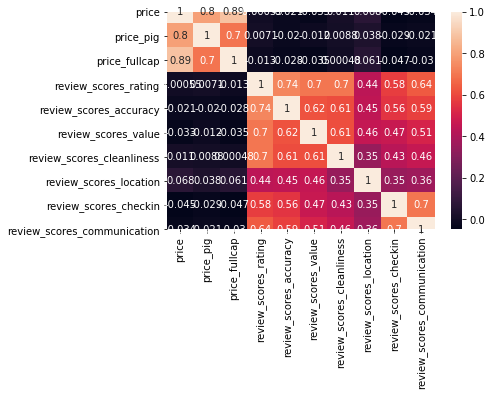

,price,price_pig,price_fullcap,review_scores_rating,review_scores_accuracy,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_checkin,review_scores_communication
price,1.000000,0.798673,0.886460,-0.000553,-0.021020,-0.032975,0.011040,0.068093,-0.044644,-0.033658
price_pig,0.798673,1.000000,0.696830,0.007140,-0.019539,-0.011804,0.008768,0.038426,-0.029216,-0.020944
price_fullcap,0.886460,0.696830,1.000000,-0.012691,-0.027888,-0.035162,0.000482,0.060550,-0.046868,-0.030129
review_scores_rating,-0.000553,0.007140,-0.012691,1.000000,0.737991,0.698410,0.701303,0.438368,0.578137,0.636266
review_scores_accuracy,-0.021020,-0.019539,-0.027888,0.737991,1.000000,0.621030,0.610890,0.445276,0.558084,0.586809
review_scores_value,-0.032975,-0.011804,-0.035162,0.698410,0.621030,1.000000,0.614639,0.456567,0.467039,0.508239
review_scores_cleanliness,0.011040,0.008768,0.000482,0.701303,0.610890,0.614639,1.000000,0.348256,0.430509,0.460374
review_scores_location,0.068093,0.038426,0.060550,0.438368,0.445276,0.456567,0.348256,1.000000,0.353521,0.362297
review_scores_checkin,-0.044644,-0.029216,-0.046868,0.578137,0.558084,0.467039,0.430509,0.353521,1.000000,0.698630
review_scores_communication,-0.033658,-0.020944,-0.030129,0.636266,0.586809,0.508239,0.460374,0.362297,0.698630,1.000000


In [36]:
corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_checkin', 'review_scores_communication']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

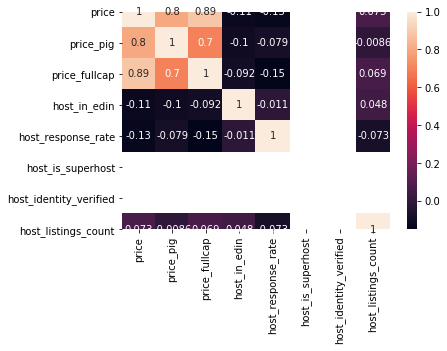

,price,price_pig,price_fullcap,host_in_edin,host_response_rate,host_is_superhost,host_identity_verified,host_listings_count
price,1.000000,0.798673,0.886460,-0.114619,-0.130417,NaN,NaN,0.073112
price_pig,0.798673,1.000000,0.696830,-0.101520,-0.079499,NaN,NaN,-0.008572
price_fullcap,0.886460,0.696830,1.000000,-0.092039,-0.149333,NaN,NaN,0.068992
host_in_edin,-0.114619,-0.101520,-0.092039,1.000000,-0.010690,NaN,NaN,0.047576
host_response_rate,-0.130417,-0.079499,-0.149333,-0.010690,1.000000,NaN,NaN,-0.073418
host_is_superhost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_identity_verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,0.073112,-0.008572,0.068992,0.047576,-0.073418,NaN,NaN,1.000000


In [37]:
corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'host_in_edin', 'host_response_rate', 'host_is_superhost', 'host_identity_verified', 'host_listings_count']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Finalising the Dataset

In [38]:
listings.to_csv('../data20/listings2020_cleaned.csv', index = False)